# Bitcoin Price Analysis 

## Imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter

## Fetching BTC prices

In [2]:
BTC_USD = yf.download("BTC-USD", start='2019-01-03', end='2022-04-16', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
BTC_USD.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824
2019-01-06,3836.519043,4093.297363,3826.513184,4076.632568,4076.632568,5597027440


## Plotting Price Chart

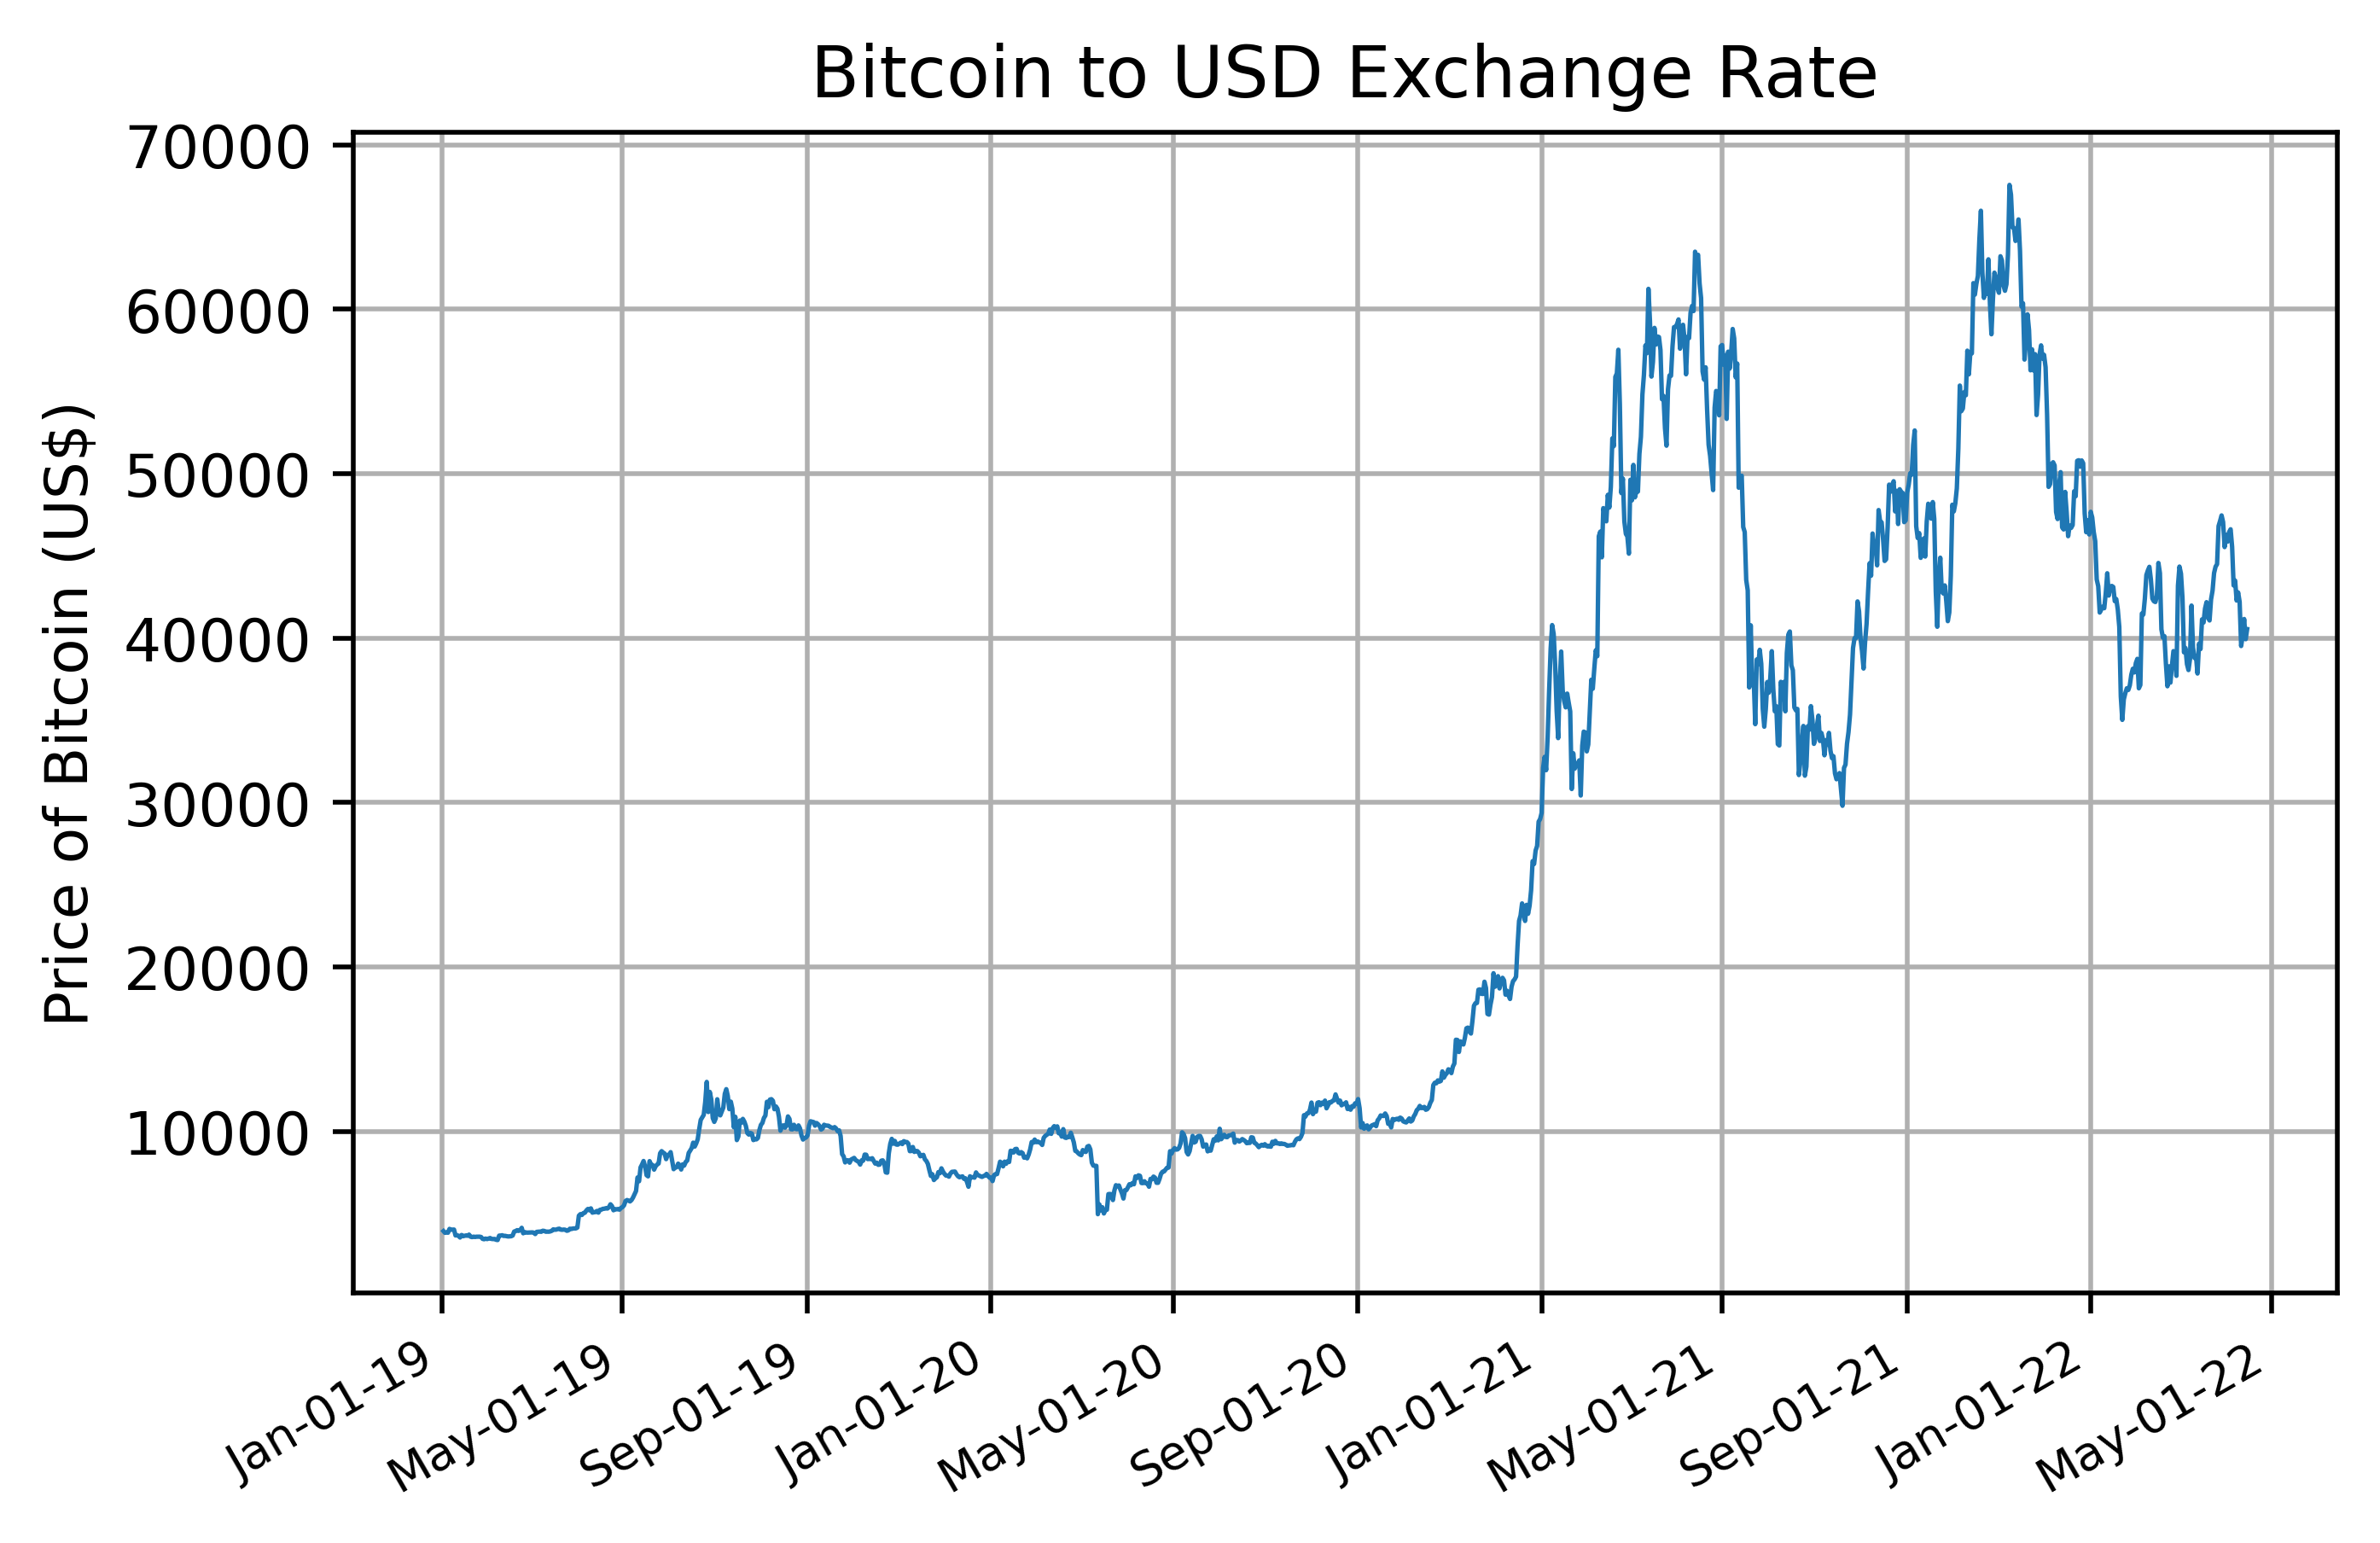

In [4]:
fig, ax = plt.subplots(dpi=500)

date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()

ax.plot(BTC_USD['Close'], lw=0.75)

ax.set_ylabel('Price of Bitcoin (US$)')
ax.set_title('Bitcoin to USD Exchange Rate')
ax.grid()

plt.show()

## Compute Simple Moving Averages

Simple Moving Averages are very common in analysing and predicting prices in trading. Here, I am computing 9 day and 30 day moving averages.

In [5]:
BTC_USD['SMA_9'] = BTC_USD['Close'].rolling(window=9, min_periods=1).mean()

In [6]:
BTC_USD['SMA_30'] = BTC_USD['Close'].rolling(window = 30, min_periods=1).mean()

In [7]:
BTC_USD.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_9,SMA_30
Date,,,,,,,,
2022-04-11,42201.039062,42424.589844,39373.058594,39521.902344,39521.902344,33949912166,43571.355035,43387.958464
2022-04-12,39533.714844,40617.585938,39388.328125,40127.183594,40127.183594,30991500854,42868.423611,43463.875781
2022-04-13,40123.570312,41430.054688,39712.746094,41166.730469,41166.730469,27691105228,42262.207465,43513.875000
2022-04-14,41160.218750,41451.480469,39695.746094,39935.515625,39935.515625,24342001973,41637.710069,43533.766016
2022-04-15,39939.402344,40617.722656,39866.832031,40553.464844,40553.464844,21756855753,41342.901910,43514.083854


## Plotting SMAs

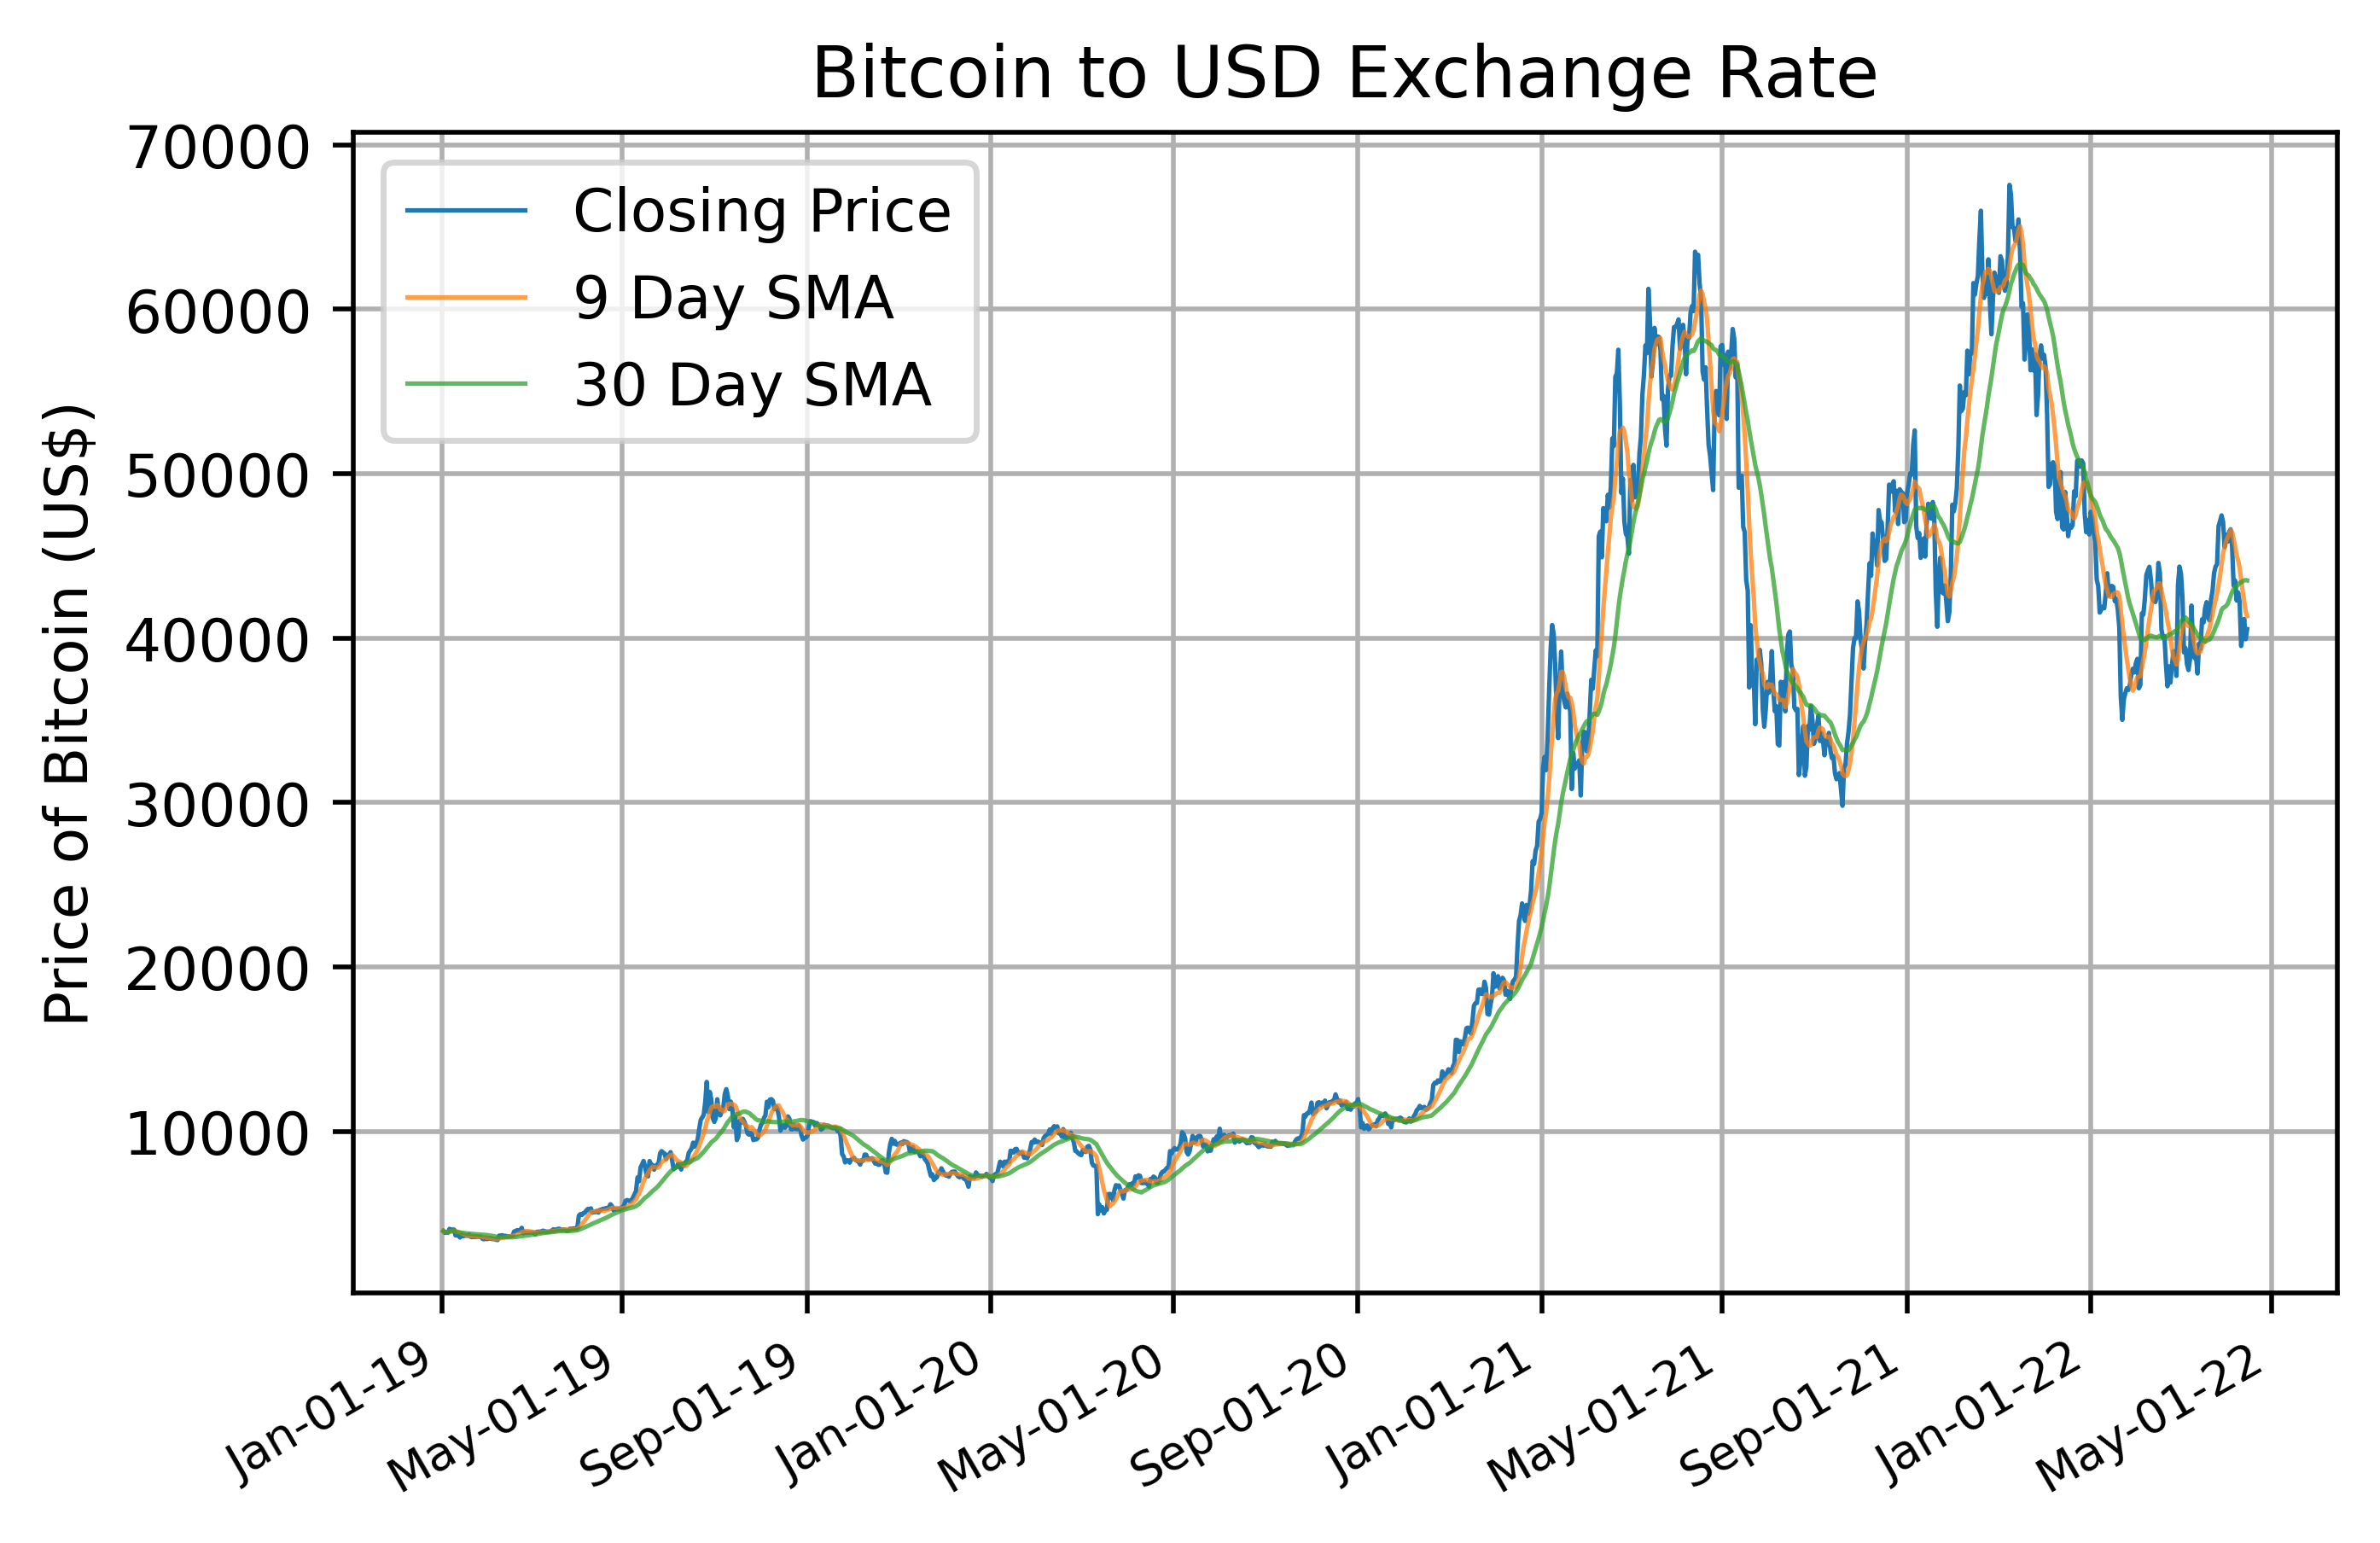

In [8]:
fig, ax = plt.subplots(dpi=500)

date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()

ax.plot(BTC_USD['Close'], lw=0.75, label='Closing Price')

ax.plot(BTC_USD['SMA_9'], lw=0.75, alpha=0.75, label='9 Day SMA')
ax.plot(BTC_USD['SMA_30'], lw=0.75, alpha=0.75, label='30 Day SMA')

ax.set_ylabel('Price of Bitcoin (US$)')
ax.set_title('Bitcoin to USD Exchange Rate')
ax.grid()
ax.legend()

plt.show()

## Trading strategy

One of the simplest trading strategies is <b>Moving Average Crossover</b>. When the shorter moving average crosses over longer moving average, it can signal a trend reversal.<br><b>Example:</b><br>1.When shorter moving average is below longer moving average and then crosses over, it may signal a bullish (upwards) trend and this would be a buy signal.<br>2. And if shorter moving average is above longer moving average and then crosses over, it may signal a bearish (downwards) trend and this would be a sell signal.

In [9]:
trade_signals = pd.DataFrame(index=BTC_USD.index)

short_interval = 10
long_interval = 40

trade_signals['Short'] = BTC_USD['Close'].rolling(window=short_interval, min_periods=1).mean()
trade_signals['Long'] = BTC_USD['Close'].rolling(window=long_interval, min_periods=1).mean()

In [10]:
trade_signals['Signal'] = 0.0

trade_signals['Signal'] = np.where(trade_signals['Short'] > trade_signals['Long'], 1.0, 0.0)

In [11]:
trade_signals['Position'] = trade_signals['Signal'].diff()

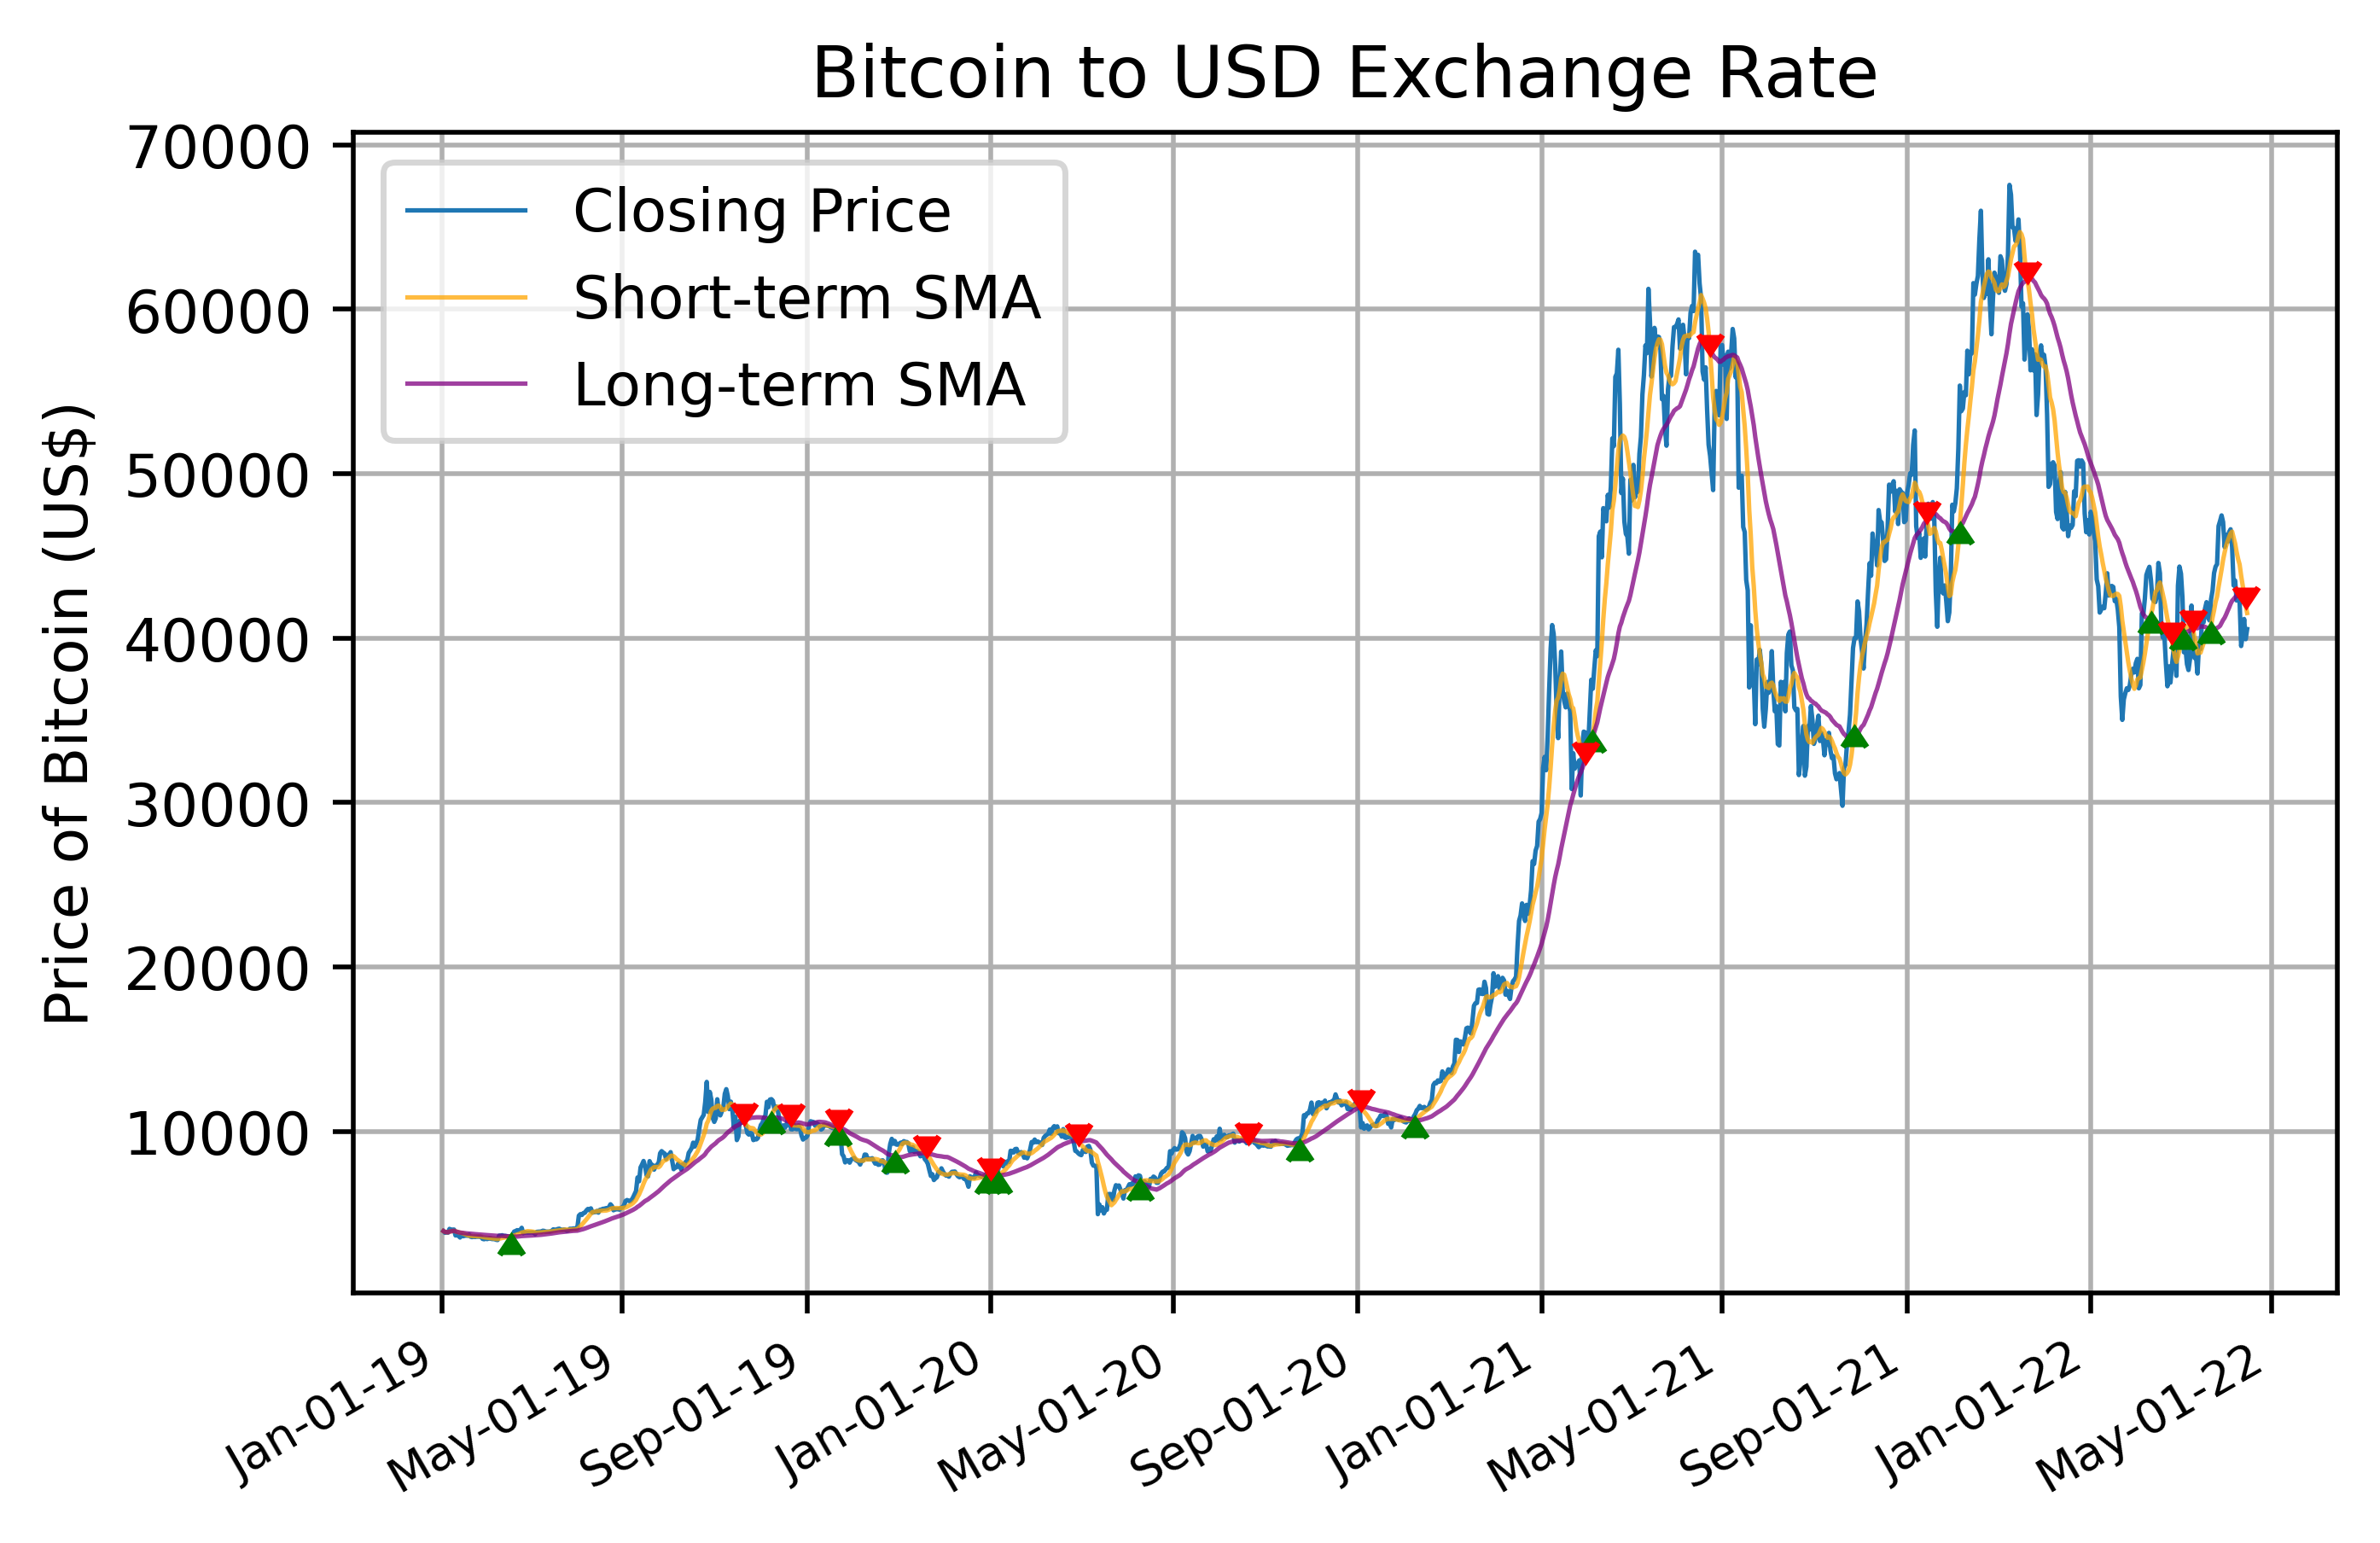

In [12]:
fig, ax = plt.subplots(dpi=500)

date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()

ax.plot(BTC_USD['Close'], lw=0.75, label='Closing Price')

ax.plot(trade_signals['Short'], lw=0.75, alpha=0.75, color='orange', label='Short-term SMA')

ax.plot(trade_signals['Long'], lw=0.75, alpha=0.75, color='purple', label='Long-term SMA')


ax.plot(trade_signals.loc[trade_signals['Position']==1.0].index, trade_signals.Short[trade_signals['Position'] == 1.0],
 marker=6, ms=4, linestyle='none', color='green')

ax.plot(trade_signals.loc[trade_signals['Position'] == -1.0].index, trade_signals.Short[trade_signals['Position'] == -1.0],
 marker=7, ms=4, linestyle='none', color='red')

ax.set_ylabel('Price of Bitcoin (US$)')
ax.set_title('Bitcoin to USD Exchange Rate')
ax.grid()
ax.legend()

plt.show()

## Backtesting the strategy

In [13]:
initial_balance = 100000.0 # I wish I had this capital :)

backtest = pd.DataFrame(index=trade_signals.index)

backtest['BTC_Return'] = BTC_USD['Close'] / BTC_USD['Close'].shift(1)

In [14]:
backtest['Alg_Return'] = np.where(trade_signals.Signal == 1, backtest.BTC_Return, 1.0)

backtest['Balance'] = initial_balance * backtest.Alg_Return.cumprod()

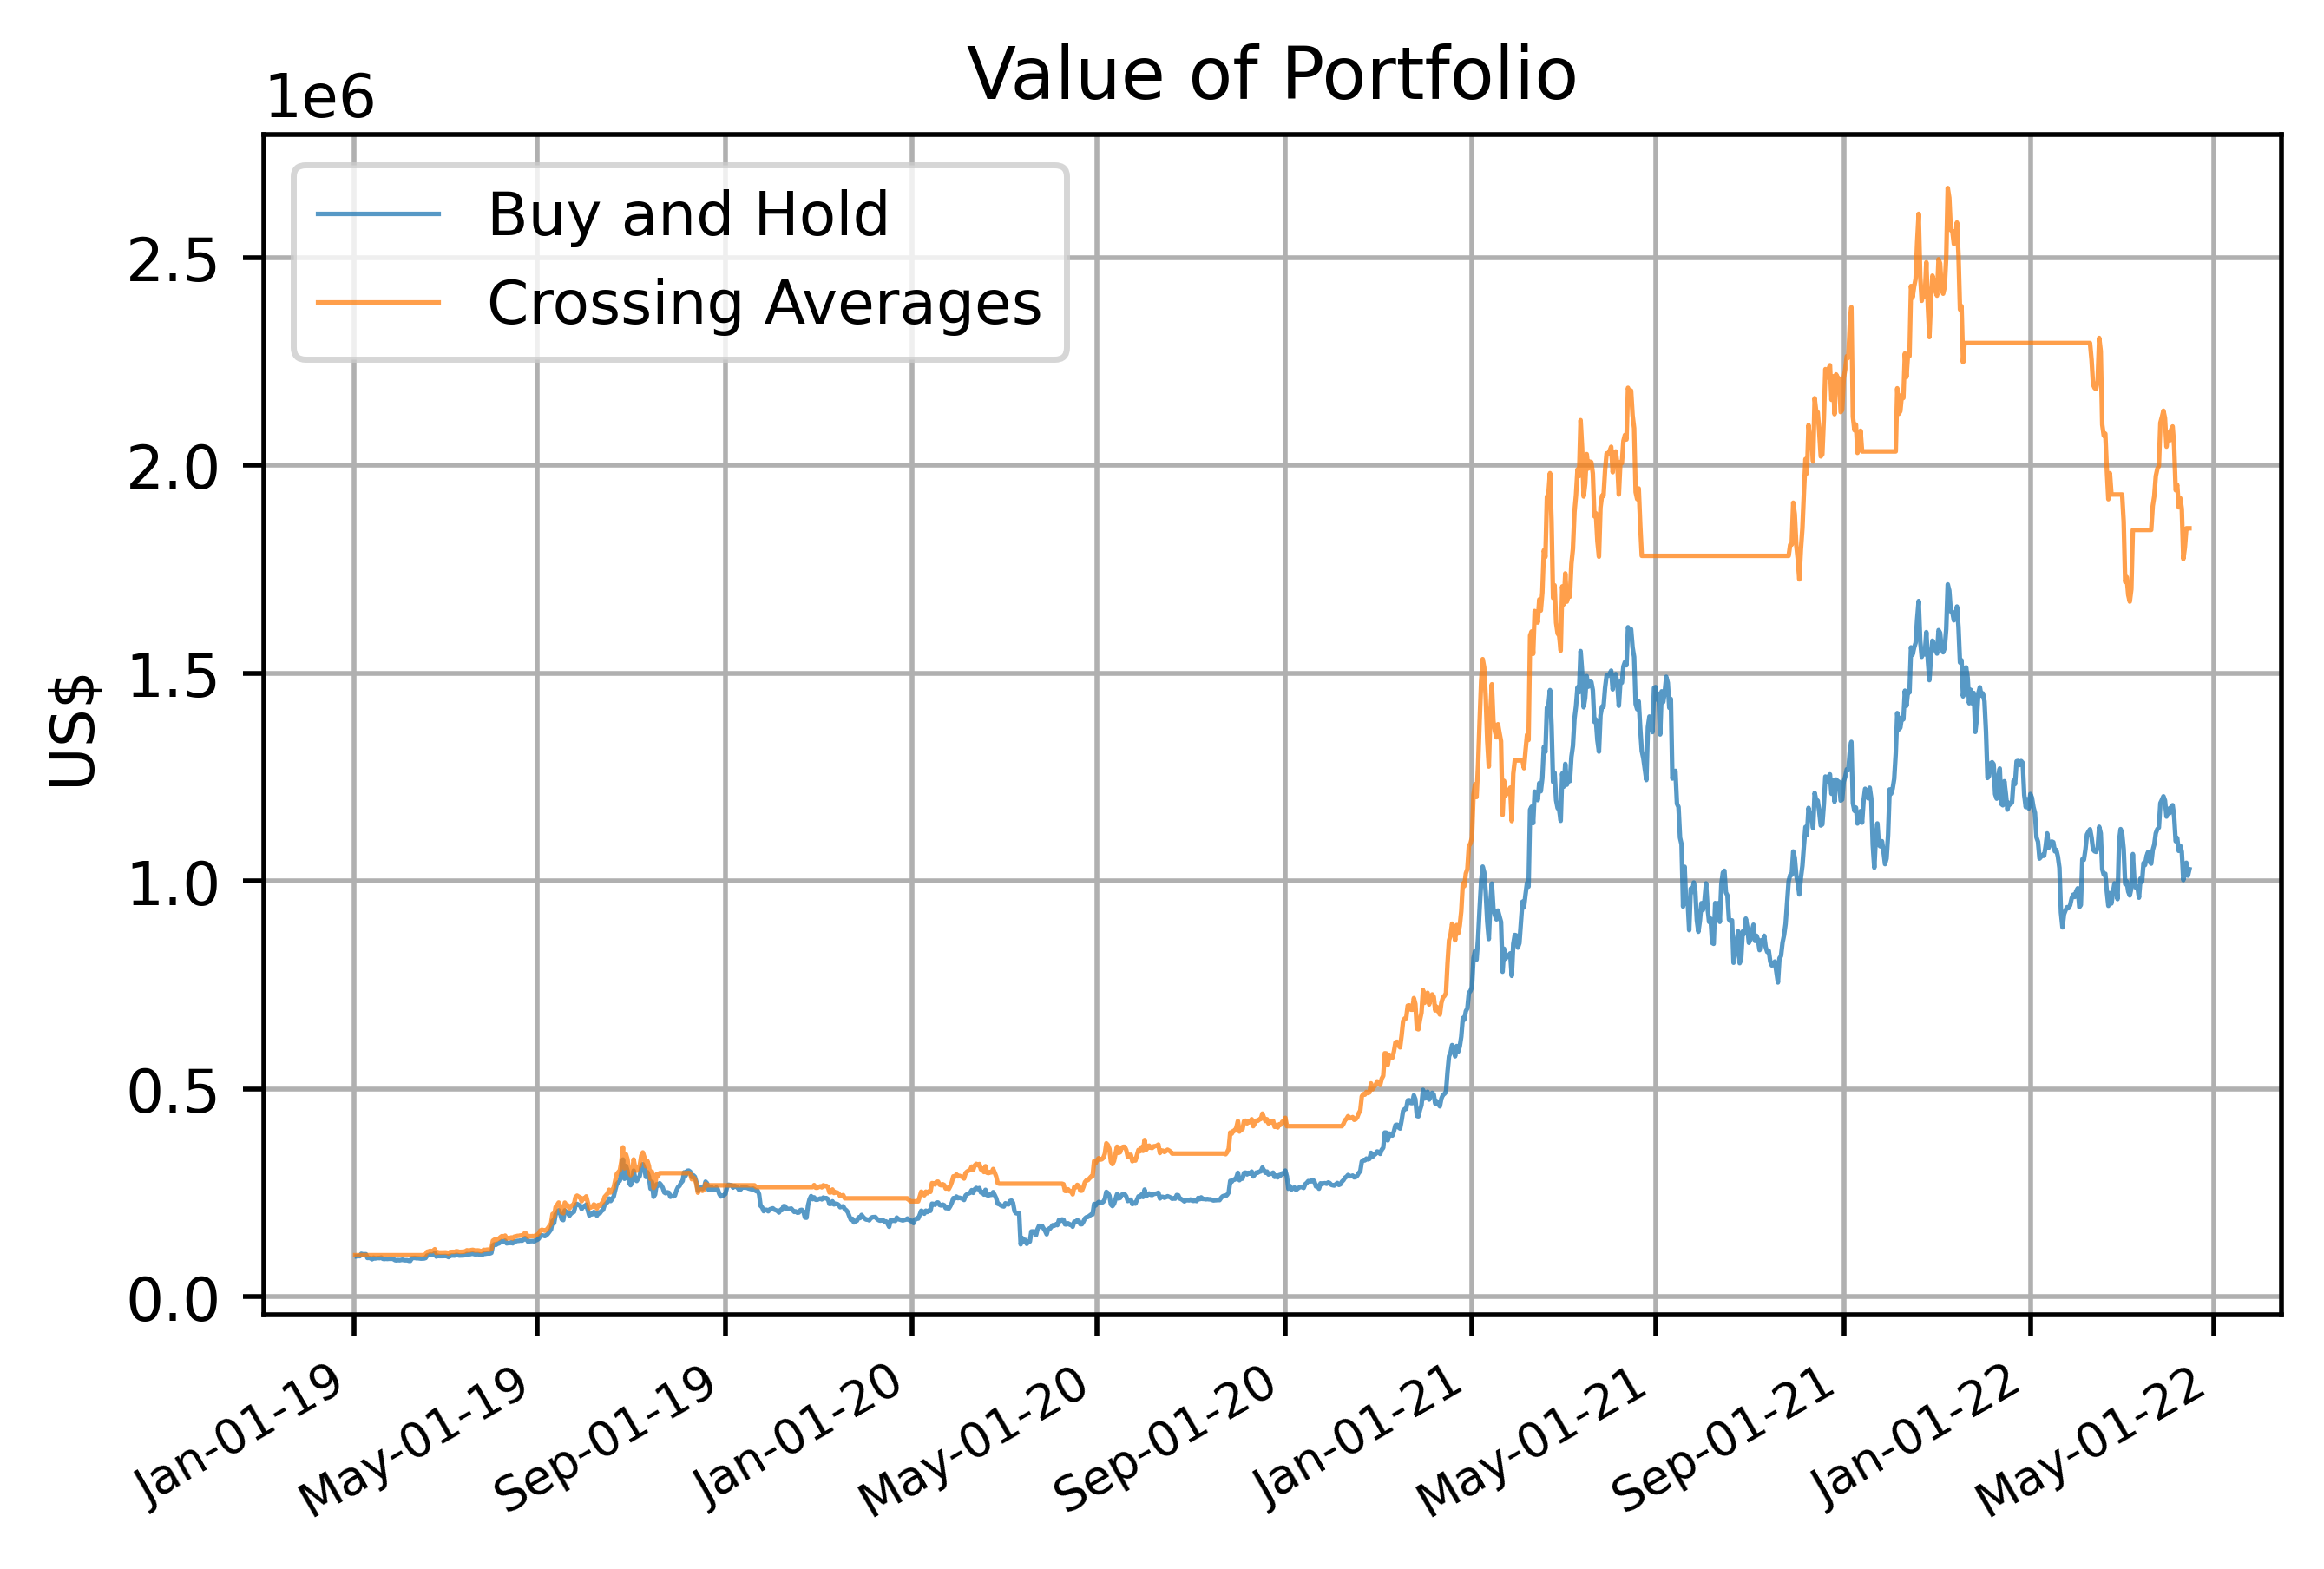

In [15]:
fig, ax = plt.subplots(dpi=500)

date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()

ax.plot(initial_balance*backtest.BTC_Return.cumprod(), lw=0.75, alpha=0.75, label='Buy and Hold')

ax.plot(backtest['Balance'], lw=0.75, alpha=0.75, label='Crossing Averages')

ax.set_ylabel('US$')
ax.set_title('Value of Portfolio')
ax.grid()
ax.legend()

plt.show()